# New Clusters

In [34]:
import os, hdbscan, itertools, time
# import hdbscan
# import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import mode
from sklearn import metrics, mixture, random_projection

from sklearn.manifold import MDS

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD, SparsePCA

from sklearn.metrics import silhouette_samples, silhouette_score, consensus_score
from sklearn.decomposition import RandomizedPCA, PCA, KernelPCA, IncrementalPCA
from sklearn.cross_validation import train_test_split
from sklearn.cluster import DBSCAN, estimate_bandwidth, MeanShift, KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph

from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
import warnings

# Utiles

In [2]:
def plot_cls(name, data, labels, alpha=.5, centers=[]):
    name_plot = name + " " + str(np.random.randint(1000))
    colores = ["r","c","b","g"]
    col = [colores[x] for x in labels]
    fig = plt.figure(name_plot, figsize=(9,6))
    ax = Axes3D(fig)
    ax.set_title("Clusters por "+name)
    grupos = data.groupby("clase")
    for i, (name, group) in enumerate(grupos):
        c = colores[i]
        ax.scatter(group[0], group[1], group[2], marker='o', c=c, alpha=alpha,
                   label="clase:{0}({1} items)".format(name, group.shape[0]))
    if len(centers)>0:
        for i, c in enumerate(centers):
            ax.text(c[0], c[1], c[2], "c %d"%i,bbox=dict(
                    facecolor='white', alpha=.5, edgecolor='black', boxstyle='round'))
    ax.legend(loc=4)
    plt.show()

def clases_bolsa(data):
    bolsas = [[] for _ in range(12)]
    for i, j in itertools.product(range(12), range(10)):
        ind = "Bolsa {0}-{1}".format(i+1, j+1)
        if ind not in data.index:
            continue
        valor = data.loc[ind]["clase"]
        bolsas[i].append(valor)

    resultados_por_bolsa = pd.DataFrame(columns=["Clase"])
    nombre_bolsas = []
    for i, b in enumerate(bolsas):
        nombre_bolsas.append("Bolsa %d"%i)
        resultados_por_bolsa.loc[i] = [mode(b)[0][0]]
    resultados_por_bolsa.index = nombre_bolsas
#     resultados_por_bolsa.to_csv("Resultados_x_bolsa.csv", sep="\t")
    display(resultados_por_bolsa.T)

new_index = []
for i, j in itertools.product(range(12),range(10)):
    new_index.append('Bolsa {0}-{1}'.format(i+1,j+1))
new_index.remove('Bolsa 4-3')

In [22]:
pca_totales = pd.DataFrame()
datos = []
files = os.listdir("SojaData/")

for i in range(15):
    for j in range(12):
        pca_temp = np.array([])

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        pca_file = RandomizedPCA(n_components=3, random_state=1).fit_transform(df)
        pca_file = np.array(pca_file)
        
        n_cols = pca_file.shape[0] * pca_file.shape[1]
        pca_file = pca_file.reshape(1, n_cols)
        pca_temp = np.append(pca_temp, pca_file)
        datos = np.append(datos,pca_file)
        pca_totales = pca_totales.append(pd.DataFrame(pca_temp).T, ignore_index=True)

pca_totales.dropna(axis=0, how="all", inplace=True)
pca_totales.fillna(value=0,axis=0, inplace=True)
# pca_totales[:3]

Variacion: 0.9996025939374916
MS Score: 0.8776140834453067


<IPython.core.display.Javascript object>


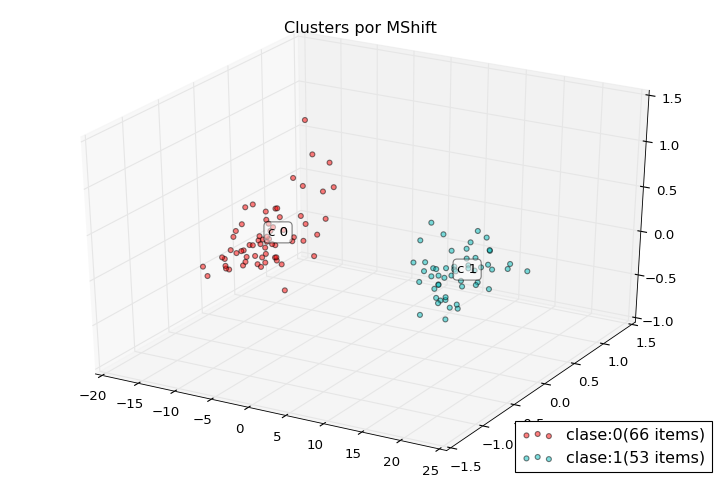

KM Score: 0.7658828840145316


<IPython.core.display.Javascript object>


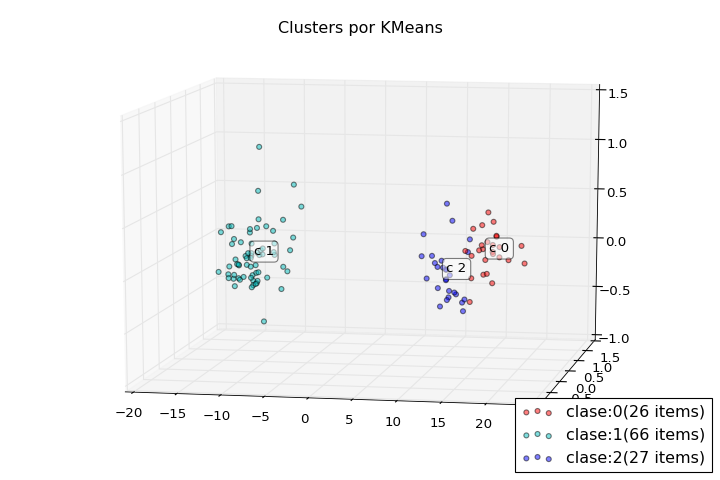

In [23]:
pca = RandomizedPCA(n_components=3, random_state=1)
datos = pca.fit_transform(pca_totales)
print("Variacion: {}".format(np.sum(pca.explained_variance_ratio_)))
d_plots = pd.DataFrame(datos)

b_width = estimate_bandwidth(datos, quantile=0.5, n_samples=datos.shape[0])
ms_ = MeanShift(bandwidth=b_width, bin_seeding=True)
ms_cls = ms_.fit_predict(datos)
d_plots["clase"] = ms_cls
ms_score = silhouette_score(datos, ms_cls)
print("MS Score: {}".format(ms_score))
plot_cls("MShift", d_plots, ms_cls, centers=ms_.cluster_centers_)

km_ = KMeans(n_clusters=3, random_state=10)
# km_.fit(datos)
km_cls = km_.fit_predict(datos)
km_score = silhouette_score(datos, km_cls)
print("KM Score: {}".format(km_score))
d_plots["clase"] = km_cls
plot_cls("KMeans", d_plots, km_cls, centers=km_.cluster_centers_)

In [7]:
print("MShift:\n\tClusters: {} \n\tS_Score: {}".format(len(np.unique(ms_.labels_)), ms_score))
print("KMeans:\n\tClusters: {} \n\tS_Score: {}".format(len(np.unique(km_.labels_)), km_score))
d_plots.index = new_index
# clases_bolsa(d_plots)

MShift:
	Clusters: 2 
	S_Score: 0.8776140834453067
KMeans:
	Clusters: 3 
	S_Score: 0.7658828840145316


In [24]:
pca_bolsas_unidas = pd.DataFrame()
pca_bolsas = []
files = os.listdir("SojaData/")

for i in range(15):
    pca_temp = np.array([])
    for j in range(12):

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        pca_file = PCA(n_components=3).fit_transform(df)
        pca_file = np.array(pca_file)
        
        n_cols = pca_file.shape[0] * pca_file.shape[1]
        pca_file = pca_file.reshape(1, n_cols)
        pca_temp = np.append(pca_temp, pca_file)
        pca_bolsas = np.append(pca_bolsas,pca_file)
    pca_bolsas_unidas = pca_bolsas_unidas.append(pd.DataFrame(pca_temp).T, ignore_index=True)

pca_bolsas_unidas.dropna(axis=0, how="all", inplace=True)
pca_bolsas_unidas.fillna(value=0,axis=0, inplace=True)
pca_bolsas_unidas.shape

(12, 15030)

Variación: 0.9918408597564229
GMM Silohuete Score: 0.26381659616292435


<IPython.core.display.Javascript object>


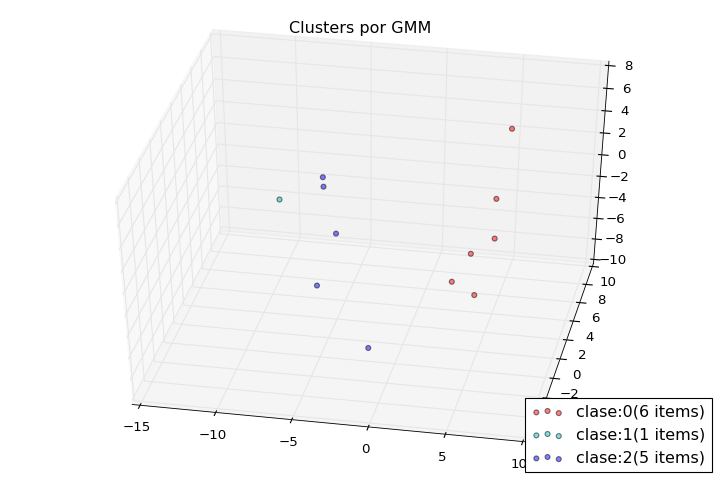

KM Silohuete Score: 0.26381659616292435


<IPython.core.display.Javascript object>


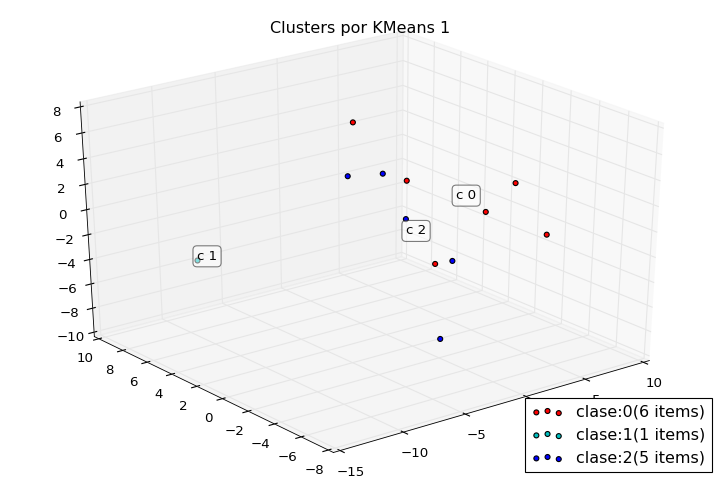

In [26]:
pca_gen = PCA(n_components=9)
datos_bolsas = pca_gen.fit_transform(pca_bolsas_unidas)
print("Variación: {}".format(np.sum(pca_gen.explained_variance_ratio_)))
d_plot_bolsas = pd.DataFrame(datos_bolsas)

gmm_ = mixture.GMM(n_components=3, covariance_type='tied')
gmm_cls = gmm_.fit_predict(datos_bolsas)

gmm_sa = silhouette_score(d_plot_bolsas, gmm_cls)
gmm_ssv = silhouette_samples(d_plot_bolsas, gmm_cls, "sqeuclidean")
print("GMM Silohuete Score: {}".format(gmm_sa))
d_plot_bolsas["clase"] = gmm_cls
plot_cls("GMM", d_plot_bolsas, gmm_cls)

kmb_ = KMeans(n_clusters=3, random_state=10)
kmb_.fit(datos_bolsas)
kmb_cls = kmb_.predict(datos_bolsas)
kmb_score = silhouette_score(datos_bolsas, kmb_cls)
print("KM Silohuete Score: {}".format(kmb_score))
d_plot_bolsas["clase"] = kmb_cls
plot_cls("KMeans 1", d_plot_bolsas, kmb_cls, alpha=1, centers=kmb_.cluster_centers_)

# Probando Algoritmos de extraccion de Features

In [89]:
%%time
# from sklearn.manifold import Isomap, LocallyLinearEmbedding

pca_totales = pd.DataFrame()
datos = pd.DataFrame()
files = os.listdir("SojaData/")

df_temp = pd.DataFrame()
for i in range(12):
    for j in range(10):
        pca_temp = np.array([])

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i+1, j+1)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        n_df = pd.DataFrame( np.array(df).reshape(1,-1) )
        df_temp = pd.concat([df_temp, n_df], ignore_index=True)

#         pca_file = RandomizedPCA(n_components=3, random_state=1).fit_transform(df)
#         pca = random_projection.GaussianRandomProjection(n_components=3)
#         pca = KernelPCA(n_components=3, kernel="sigmoid") # "linear" | "poly" | "rbf" | "sigmoid" | "cosine" | "precomputed"
#         pca = PCA(n_components=3)

#         vt = VarianceThreshold(.8 * (1 - .8))
#         n_df = vt.fit_transform(df)
        pca = MDS(n_components=3, n_jobs=4, random_state=10, eps=1e-8)
        pca_file = pca.fit_transform(df)
        pca_file = np.array(pca_file)
    
#         pca_file = np.array(df)
        pca_file = pca_file.reshape(1, -1)
        pca_temp = np.append(pca_temp, pca_file)
        datos = np.append(datos,pca_file)    
        pca_totales = pca_totales.append(pd.DataFrame(pca_temp).T, ignore_index=True)

# print(pca.stress_)

#     df_temp.fillna(value=-1, axis=1, inplace=True)
#     datos = datos.append(df_temp, ignore_index=True)
#     df_temp = pd.DataFrame()

# pca_totales.fillna(value=-1, axis=1, inplace=True)
# vt = VarianceThreshold(.8 * (1 - .8))
# pca_totales = vt.fit_transform(pca_totales)

# pca = MDS(n_components=3, n_jobs=4, random_state=20, eps=1e-6)
# pca_totales = pca.fit_transform(datos)

CPU times: user 13.7 s, sys: 21.3 s, total: 35.1 s
Wall time: 19min 33s


In [91]:
pd.DataFrame(pca_totales).fillna(value=-1, axis=1, inplace=True)
vt = VarianceThreshold(.8 * (1 - .8))
n_pca_totales = vt.fit_transform(pca_totales)
n_pca_totales.shape

(119, 167)

Silohuete Score: 0.885929


<IPython.core.display.Javascript object>


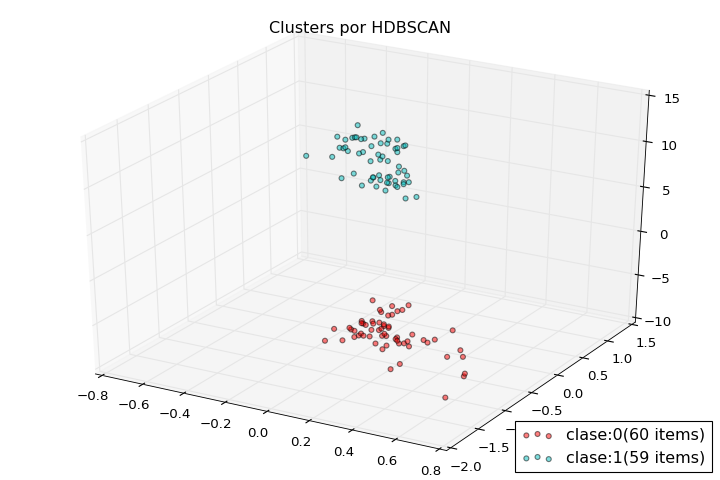

KM Score: 0.7782317434882428


<IPython.core.display.Javascript object>


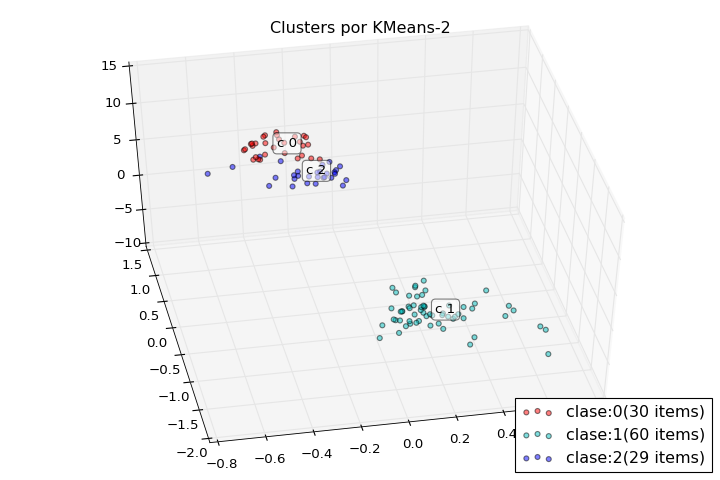

,Bolsa 0,Bolsa 1,Bolsa 2,Bolsa 3,Bolsa 4,Bolsa 5,Bolsa 6,Bolsa 7,Bolsa 8,Bolsa 9,Bolsa 10,Bolsa 11
Clase,1.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,0.0


In [92]:
pca_n = MDS(n_components=3, n_jobs=4, random_state=20, eps=1e-9)
d_plots = pd.DataFrame(pca_n.fit_transform(n_pca_totales))

# print("Variacion: {}".format(np.sum(pca.explained_variance_ratio_)))

km_ = KMeans(n_clusters=3)
km_.fit(d_plots)
    
hdb_ = hdbscan.HDBSCAN(min_cluster_size=10)

hdb_cls = hdb_.fit_predict(d_plots)
hdb_ss = silhouette_score(d_plots, hdb_cls)
print("Silohuete Score: %f"%hdb_ss)
hdb_ssv = silhouette_samples(d_plots, hdb_cls)
d_plots["clase"] = hdb_cls
plot_cls("HDBSCAN", d_plots, hdb_cls)


km_cls = km_.predict(d_plots.iloc[:,:-1])
km_score = silhouette_score(d_plots, km_cls)
print("KM Score: {}".format(km_score))
d_plots["clase"] = km_cls
d_plots.index = new_index
plot_cls("KMeans-2", d_plots, km_cls, centers=km_.cluster_centers_)
clases_bolsa(d_plots)

In [97]:
d_plots.query("clase == 2")["clase"].T

Bolsa 2-6     2
Bolsa 3-4     2
Bolsa 3-5     2
Bolsa 4-5     2
Bolsa 5-1     2
Bolsa 5-5     2
Bolsa 5-6     2
Bolsa 6-3     2
Bolsa 6-4     2
Bolsa 7-1     2
Bolsa 7-2     2
Bolsa 7-4     2
Bolsa 7-8     2
Bolsa 7-9     2
Bolsa 7-10    2
Bolsa 8-2     2
Bolsa 8-4     2
Bolsa 8-5     2
Bolsa 9-9     2
Bolsa 10-1    2
Bolsa 10-5    2
Bolsa 10-6    2
Bolsa 10-7    2
Bolsa 10-8    2
Bolsa 11-1    2
Bolsa 11-7    2
Bolsa 12-1    2
Bolsa 12-7    2
Bolsa 12-9    2
Name: clase, dtype: int32

array([  9.98122985e-01,   1.20113603e-03,   5.74425402e-04])